# Analysis

## Initialization

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.tools.eval_measures import rmse, meanabs, mse

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Utilities

def print_cols(data, padding=1):
    max_l = max(len(str(el)) for row in data for el in row)
    for row in data:
        print((f'{{:<{padding + max_l}}}' * len(row)).format(*row))


def logret(frame):
    return (np.log(frame) - np.log(frame).shift(1)).dropna()


def revlogret(frame, init_term):
    return np.exp(frame.cumsum() + np.log(init_term))


def evals(testframe, predframe, tickers):
    cols = [
        ['Stock', 'RMSE', 'MAE', 'MSE'],
        ['------------------'] * 4,
    ]

    for ticker in tickers:
        cols.append([
            ticker,
            rmse(testframe[ticker], predframe[ticker]),
            meanabs(testframe[ticker], predframe[ticker]),
            mse(testframe[ticker], predframe[ticker])
        ])
    
    print_cols(cols)


In [3]:
TICKERS = [
    'AAPL',  # Apple
    'AMZN',  # Amazon
    'GM',    # General Motors
    'JNJ',   # Johnson & Johnson
    'XOM',   # ExxonMobil
]

FIGSIZE = (13, 8)

## Load Data and Visualize

In [4]:
df = pd.read_csv(f'data/{TICKERS[0]}.csv', index_col='Date', parse_dates=['Date'])
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df.rename(columns={'Close': 'AAPL'}, inplace=True)

for ticker in TICKERS:
    tmddf = pd.read_csv(f'data/{ticker}.csv', index_col='Date', parse_dates=['Date'])
    df[ticker] = tmddf['Close']

df.head()

,AAPL,AMZN,GM,JNJ,XOM
Date,,,,,
2020-03-17,63.215000,1807.839966,20.320000,136.589996,36.810001
2020-03-18,61.667500,1830.000000,16.799999,134.960007,33.119999
2020-03-19,61.195000,1880.930054,17.709999,127.050003,34.430000
2020-03-20,57.310001,1846.089966,18.139999,119.889999,32.740002
2020-03-23,56.092499,1902.829956,17.600000,111.139999,31.450001


In [5]:
len(df)  # Rows in the dataset

253

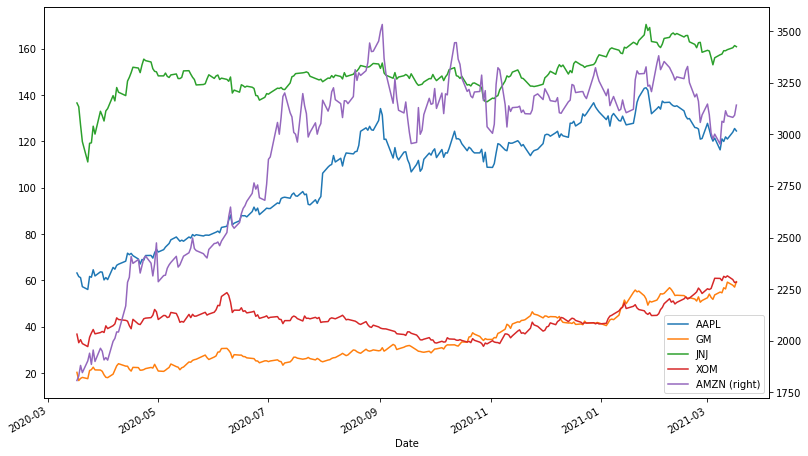

In [6]:
ax = df[[t for t in TICKERS if t != 'AMZN']].plot(figsize=FIGSIZE)
df[['AMZN']].plot(secondary_y=True, ax=ax)
plt.savefig('figs/data',bbox_inches='tight')
plt.show()

## Statistical Tests and Transformations

In [7]:
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
for ticker in TICKERS:
    adf_test(df[ticker], title=ticker)
    print()

Augmented Dickey-Fuller Test: AAPL
ADF test statistic       -1.701756
p-value                   0.430208
# lags used               0.000000
# observations          252.000000
critical value (1%)      -3.456569
critical value (5%)      -2.873079
critical value (10%)     -2.572919
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: AMZN
ADF test statistic       -2.836689
p-value                   0.053221
# lags used               3.000000
# observations          249.000000
critical value (1%)      -3.456888
critical value (5%)      -2.873219
critical value (10%)     -2.572994
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: GM
ADF test statistic        0.325325
p-value                   0.978477
# lags used               0.000000
# observations          252.000000
critical value (1%)      

As we can see, all the series are non-stationary, so we will take the first difference (and also apply a log transformation because these are stock prices):

In [9]:
df1d = pd.DataFrame(logret(df))

for ticker in TICKERS:
    adf_test(df1d[ticker], title=ticker)
    print()

Augmented Dickey-Fuller Test: AAPL
ADF test statistic     -1.767079e+01
p-value                 3.645620e-30
# lags used             0.000000e+00
# observations          2.510000e+02
critical value (1%)    -3.456674e+00
critical value (5%)    -2.873125e+00
critical value (10%)   -2.572944e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: AMZN
ADF test statistic     -1.049537e+01
p-value                 1.119123e-18
# lags used             2.000000e+00
# observations          2.490000e+02
critical value (1%)    -3.456888e+00
critical value (5%)    -2.873219e+00
critical value (10%)   -2.572994e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: GM
ADF test statistic     -1.646259e+01
p-value                 2.322668e-29
# lags used             0.000000e+00
# observations          2.510000e+02
critica

According to the Augmented Dickey-Fuller Test, all the series are now stationary, and we can therefore proceed with the transformed data to further analysis.

In [10]:
OBS = 7  # The "length" of our predictions will be 7 days.

We split our data to training and testing datasets:

In [11]:
train = df[:-OBS]
train1d = df1d[:-OBS]
test = df[-OBS:]

## Vector Autoregression

First, we perform Vector Autoregressions of lag orders from 1 to 10, in order to select the optimal.

The optimal is the one that minimizes the Akaike Information Criterion (AIC).

For completeness, we also show the BIC (Bayesian Information Criterion, also known as Schwarz Information Criterion).

In [12]:
tmpdf = pd.DataFrame(columns=['Order', 'AIC', 'BIC'])

for i in range(1, 10):
    model = VAR(train1d)
    results = model.fit(i)
    tmpdf.loc[i] = pd.Series({'Order': i, 'AIC': results.aic, 'BIC': results.bic})

tmpdf

,Order,AIC,BIC
1,1.0,-38.487361,-38.057381
2,2.0,-38.589557,-37.798946
3,3.0,-38.558152,-37.404785
4,4.0,-38.580178,-37.061906
5,5.0,-38.690278,-36.804932
6,6.0,-38.679816,-36.425206
7,7.0,-38.605015,-35.978928
8,8.0,-38.571376,-35.571578
9,9.0,-38.569295,-35.193527


In [13]:
lag_order = tmpdf.idxmin()['AIC']

We see that the AIC is minimized for the VAR(5) model, so this will be the order of choice for the VAR model.

We proceed to train the model:

In [14]:
model = VAR(train1d)
model_fitted = model.fit(lag_order)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Apr, 2021
Time:                     22:42:21
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -36.8049
Nobs:                     240.000    HQIC:                  -37.9306
Log likelihood:           3070.11    FPE:                1.58081e-17
AIC:                     -38.6903    Det(Omega_mle):     9.45208e-18
--------------------------------------------------------------------
Results for equation AAPL
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.002493         0.001676            1.487           0.137
L1.AAPL         0.000371         0.099633            0.004           0.997
L1.AMZN        -0.051456         0.105345           -0.488           0.625
L1.GM     

Predictions:

In [15]:
preds_var_1d = pd.DataFrame(
    model_fitted.forecast(y=train1d.values[-lag_order:], steps=OBS),
    columns=TICKERS,
    index=test.index.copy())

Evaluation of the forecast:
  - Visualization of the forecast
  - Root Mean Square Error, Mean Absolute Error, Mean Square Error used as evaluation metrics

In [16]:
preds_var = revlogret(preds_var_1d, df.iloc[-OBS-1].values)
preds_var  # VAR Predictions

,AAPL,AMZN,GM,JNJ,XOM
Date,,,,,
2021-03-09,117.537530,2978.271659,54.824307,157.686122,60.790878
2021-03-10,117.952497,2985.612046,56.276787,156.776397,61.818153
2021-03-11,118.118905,2987.650181,57.663921,157.476751,62.992500
2021-03-12,118.739688,2988.838073,57.872513,157.540823,63.424863
2021-03-15,119.420462,3011.755608,57.207275,157.734188,63.138570
2021-03-16,120.075668,3015.835803,57.161380,158.082170,63.177330
2021-03-17,120.325251,3022.327709,57.325100,158.514231,63.006188


In [17]:
test  # Original Test Data

,AAPL,AMZN,GM,JNJ,XOM
Date,,,,,
2021-03-09,121.089996,3062.850098,54.650002,157.699997,59.930000
2021-03-10,119.980003,3057.639893,56.830002,159.149994,61.770000
2021-03-11,121.959999,3113.590088,56.330002,159.139999,61.310001
2021-03-12,121.029999,3089.489990,59.259998,159.600006,61.970001
2021-03-15,123.989998,3081.679932,57.939999,160.419998,60.389999
2021-03-16,125.570000,3091.860107,57.119999,161.369995,59.110001
2021-03-17,124.514999,3141.010010,59.480000,160.884995,59.255001


In [18]:
evals(test, preds_var, TICKERS)

Stock              RMSE               MAE                MSE                
------------------ ------------------ ------------------ ------------------ 
AAPL               3.8794819820419333 3.7092848332803317 15.050380448988006 
AMZN               94.93440299943956  92.54700559922776  9012.540872859998  
GM                 1.147859643474506  0.9111326642515252 1.3175817611174203 
JNJ                2.2767354919336364 2.0649001780869054 5.1835245002302965 
XOM                2.503142919806605  2.0876400046291357 6.265724476977937  


## Auto Regressive Integrated Moving Average

Now we move on to ARIMA models.

First, we select the optimal model according to the Akaike Information Criterion again:

In [19]:
order = {}

cols = [
    ['Stock', 'Optimal ARMA Order']
]

for ticker in TICKERS:
    recomm = arma_order_select_ic(train1d[ticker], ic='aic')['aic_min_order']
    order[ticker] = recomm
    cols.append([ticker, str(recomm)])

print_cols(cols)

Stock              Optimal ARMA Order 
AAPL               (1, 0)             
AMZN               (0, 0)             
GM                 (3, 2)             
JNJ                (4, 2)             
XOM                (2, 2)             


In [20]:
models = {}

for ticker in TICKERS:
    models[ticker] = ARMA(train1d[ticker], order=order[ticker]).fit()
    print(models[ticker].summary())
    print()

                              ARMA Model Results                              
Dep. Variable:                   AAPL   No. Observations:                  245
Model:                     ARMA(1, 0)   Log Likelihood                 559.460
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 07 Apr 2021   AIC                          -1112.921
Time:                        22:42:31   BIC                          -1102.417
Sample:                             0   HQIC                         -1108.691
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.751      0.080      -0.000       0.005
ar.L1.AAPL    -0.0968      0.064     -1.511      0.131      -0.222       0.029
                                    Roots           

In [21]:
preds_arima_1d = pd.DataFrame(index=test.index.copy())

for ticker in TICKERS:
    predictions = models[ticker].predict(start=len(train1d), end=len(train1d) + len(test) - 1)
    predictions.index = test.index.copy()
    preds_arima_1d[ticker] = predictions

preds_arima = revlogret(preds_arima_1d, train.iloc[-1].values)
preds_arima  # ARIMA Predictions

,AAPL,AMZN,GM,JNJ,XOM
Date,,,,,
2021-03-09,117.163465,2957.863780,55.018338,158.167578,60.562701
2021-03-10,117.409049,2963.789457,55.075359,158.176011,60.202584
2021-03-11,117.709694,2969.727005,55.109667,157.949310,59.972206
2021-03-12,118.005812,2975.676448,55.207051,158.475957,59.994687
2021-03-15,118.303190,2981.637810,55.416723,158.006520,60.294949
2021-03-16,118.601267,2987.611115,55.745246,158.736182,60.796792
2021-03-17,118.900100,2993.596386,56.153219,158.233789,61.353627


In [22]:
evals(test, preds_arima, TICKERS)

Stock              RMSE               MAE                MSE                
------------------ ------------------ ------------------ ------------------ 
AAPL               4.805775808501692  4.577488114465644  23.095481121580093 
AMZN               117.16118023980027 115.45973085378311 13726.742155182967 
GM                 2.403996024170232  2.0887244270377314 5.779196884226281  
JNJ                1.8376709731470786 1.6363999230740254 3.377034605547331  
XOM                1.5027209748725667 1.341956100072425  2.2581703283219574 


## Recurrent Neural Network - Long Short-Term Memory Architecture

First we will need to apply some transformations to make the network more robust, which we will later revert to perform forecasting, like we did previously:

In [24]:
def train_and_predict(series, ticker):
    train = pd.DataFrame(series.iloc[:-OBS])
    test = pd.DataFrame(series.iloc[-OBS:])
    
    scaler = MinMaxScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    
    n_input = OBS
    n_features = 1

    generator = TimeseriesGenerator(train_scaled,
                                    train_scaled,
                                    length=n_input,
                                    batch_size=1)

    model = Sequential()
    model.add(LSTM(180, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', loss='mse')

    model.fit_generator(generator, epochs=8)

    test_predictions = []

    first_eval_batch = train_scaled[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):

        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = model.predict(current_batch)[0]

        # store prediction
        test_predictions.append(current_pred)

        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

    true_predictions = scaler.inverse_transform(test_predictions)
    return pd.DataFrame(true_predictions, columns=[ticker], index=test.index.copy())


In [25]:
preds_lstm = pd.DataFrame(index=test.index.copy())

for ticker in TICKERS:
    preds_lstm[ticker] = train_and_predict(df[ticker], ticker)

Epoch 1/8
239/239 [==============================] - 1s 2ms/step - loss: 0.0751
Epoch 2/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 3/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 4/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 5/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 6/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 7/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 8/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1/8
239/239 [==============================] - 1s 2ms/step - loss: 0.0703
Epoch 2/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 3/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 4/8
239/239 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 5/8
239/239 [=====================

In [26]:
preds_lstm

,AAPL,AMZN,GM,JNJ,XOM
Date,,,,,
2021-03-09,121.703265,2980.786818,55.952650,157.732452,60.855715
2021-03-10,121.837023,2973.267426,56.674615,158.230464,61.418915
2021-03-11,121.468185,2961.599280,57.334977,158.424801,61.887922
2021-03-12,121.506163,2951.328024,57.928432,158.609949,62.450415
2021-03-15,121.559658,2945.861897,58.682696,158.907013,63.093066
2021-03-16,121.699949,2940.749076,59.574646,159.414295,63.755760
2021-03-17,121.791157,2934.248817,60.391716,159.811214,64.444768


Evaluate on Test Data

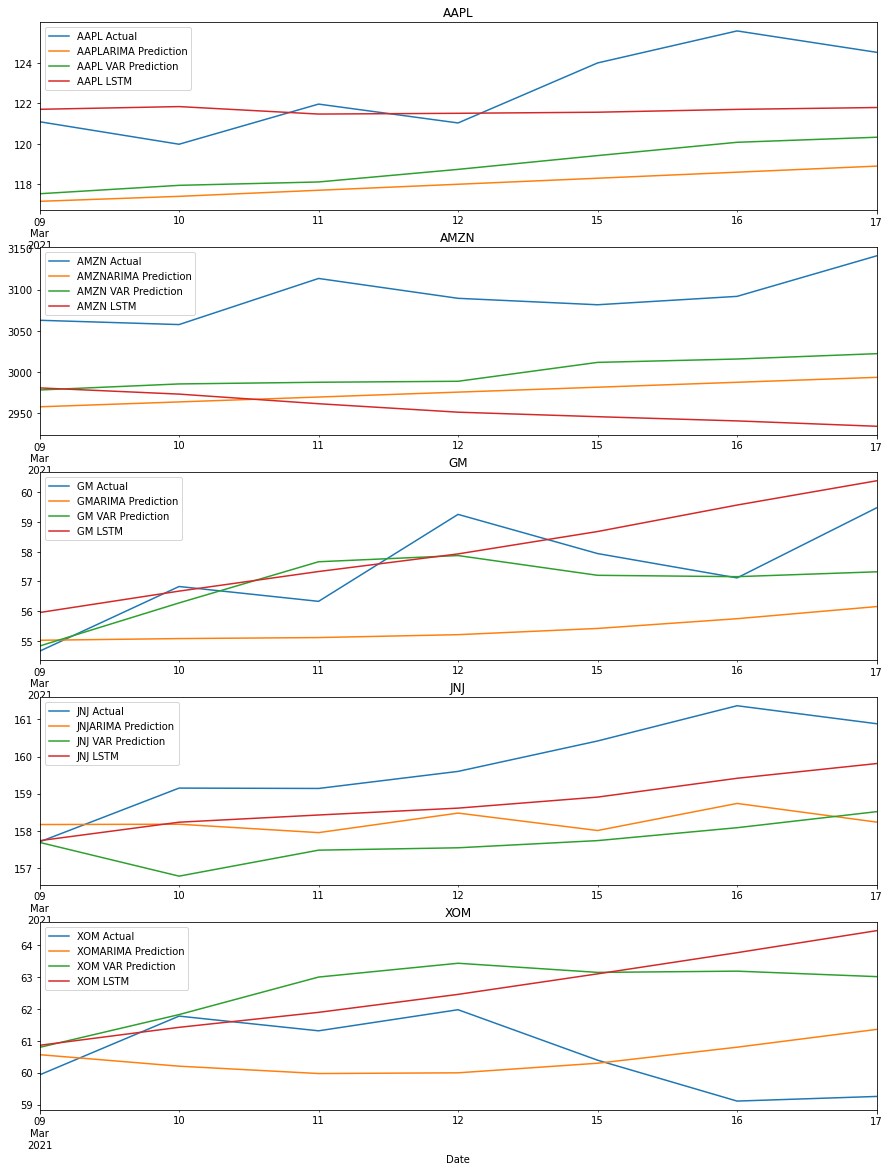

In [27]:
fig, axs = plt.subplots(5)

for ax, ticker in zip(axs, TICKERS):
    test[ticker].plot(figsize=(15, 20), title=ticker, legend=True, ax=ax, label=ticker + ' Actual')
    preds_arima[ticker].plot(legend=True, ax=ax, label=ticker + 'ARIMA Prediction')
    preds_var[ticker].plot(legend=True, ax=ax, label=ticker + ' VAR Prediction')
    preds_lstm[ticker].plot(legend=True, ax=ax, label=ticker + ' LSTM')

plt.savefig('figs/lstm')
plt.show()

In [28]:
evals(test, preds_lstm, TICKERS)

Stock              RMSE               MAE                MSE                
------------------ ------------------ ------------------ ------------------ 
AAPL               2.1579222820366137 1.7803571548355828 4.6566285753101075 
AMZN               141.45888004638152 135.75411161800275 20010.614743976555 
GM                 1.3045084631578545 1.1290908416768153 1.7017423304504675 
JNJ                1.171397000248075  1.0285292115407734 1.3721709321901883 
XOM                2.862773955992408  2.124818205654624  8.195474723108422  
